In [61]:
import os
import keyring

from typing import Annotated, Literal, List, Optional, TypedDict

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from langchain_core.messages import HumanMessage, BaseMessage
from langgraph.prebuilt import create_react_agent

from langchain_community.document_loaders import WebBaseLoader
from langchain_core.tools import tool

# Setup for tools
OPENAI_API_KEY = keyring.get_password('openai', 'key_for_mac')
TAVILY_API_KEY = keyring.get_password('tavily', 'key_for_mac')
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

# Set up LangSmith observability
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = "https://api.smith.langchain.com"
os.environ['LANGCHAIN_API_KEY'] = keyring.get_password('langsmith', 'learning_agent')
os.environ['LANGCHAIN_PROJECT'] = "pr-stupendous-hood-8"

In [62]:
# tavily search tool
tavily_tool = TavilySearchResults(max_results=5)

# Set web search and scraping tools
@tool
def scrape_webpages(urls: List[str]) -> str:
    """ Use requests and bs4 ro scrape the provideed web pages for detailed information. """
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f"\n{doc.page_content}\n"
            for doc in docs
        ]
    )
    
# Define the tools
tools = [
    tavily_tool,
    scrape_webpages
]

In [97]:
# Define sub-agents and supervisor agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage

def agent_node(state, agent, name):
    result = agent.invoke(state)
    # extracted_contentions = result.get("contentions", [])
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)], 
    }
    
def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-Based router"""
    options = ["FINISH"] + members
    
    # Define a function for OpenAI function calling : https://platform.openai.com/docs/guides/function-calling
    function_def = {
        "name": "route",
        "description": "Select the next role and provide clear instructions for the selected role to carry out",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ]
                }
            },
            "required": ["next"],
        }
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " or should we FINISH?, select one of : {options}"
            )
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

In [64]:
# Make a query analysis team
import functools
import operator

# QueryAnalysisTeam graph state
class QueryAnalysisTeamState(TypedDict):
    # A message is added after each team member finishes
    messages: Annotated[List[BaseMessage], operator.add]
    # The team members are tracked so they are aware of the other's skill-sets
    team_members: List[str]
    # Used to route work. The supervisor calls a function that will update this every time it makes a decision
    next: str
    # The list of contention extracted from the query
    contentions: List[str]

llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)

# query_system = """
# You are a text analysis specialist in a Query Analysis Team.
# Your role is to extract contentious issues from the input text that require fact-checking.

# Your task:
# 1. Analyze the user's request or question.
# 2. Extract contentious issues.
# 3. Summarize the issues for fact-checking.
# 4. List up the issues with bullet points.
# """

query_system = """
You are a text analysis specialist in a Query Analysis Team.
Your primary role is to extract contentious issues from the input text that require fact-checking.

Your Responsibilities:
	1.	Analyze the input text carefully to identify potential areas of controversy or claims requiring verification.
	2.	Extract specific contentious issues, including any claims, statistics, or opinions that might spark debate or require validation.

Output Format:
- Provide the output in the following structure:
[Briefly describe the first contentious issue or claim]
[Briefly describe the second contentious issue or claim]
...
"""

query_agent = create_react_agent(llm, tools=[], state_modifier=query_system)
query_node = functools.partial(agent_node, agent=query_agent, name="John")

summary_system = """ 
You are a text summarization specialist in a Query Analysis Team.
Your primary role is to summarize contentious issues that have been extracted by a query analyst. Your goal is to ensure the issues are clear, concise, and ready for efficient fact-checking.

Your Responsibilities:
	1.	Review the extracted contentious issues provided by the query analyst.
	2.	Summarize the issues concisely, ensuring clarity and relevance for fact-checking purposes.
	3.	Organize the summarized issues in a clear, structured format for easy reference.

Output Format:
- Summarized Contentious Issues:
	1.	[Summarized issue 1]
	2.	[Summarized issue 2]
	3.	[Summarized issue 3]
…
"""
summary_agent = create_react_agent(llm, tools=[], state_modifier=summary_system)
summary_node = functools.partial(agent_node, agent=summary_agent, name="Alicia")


supervisor_agent = create_team_supervisor(
    llm,
    "Your team is tasked with identifying and summarizing contentious issues from the given text in order to request fact-checking to a fact-finding team."
    " You are a supervisor tasked with managing a conversation between the"
    " following workers: QueryAnalysis. Given the following user input,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["QueryAnalysis", "Summarize"],
)

In [69]:
# Build a Query Team graph define chain for super layer
query_workflow = StateGraph(QueryAnalysisTeamState)
query_workflow .add_node("John", query_node)
query_workflow .add_node('Supervisor', supervisor_agent)
query_workflow.add_node('Alicia', summary_node)
query_workflow .add_edge("John", "Supervisor")
query_workflow.add_edge("Alicia", "Supervisor")
query_workflow .add_edge(START, "Supervisor")
query_workflow .add_conditional_edges(
    "Supervisor",
    lambda x: x["next"],
    {
        "QueryAnalysis": "John", 
        "Summarize": "Alicia",
        "FINISH": END
    }
)
query_graph = query_workflow .compile()

In [75]:
# The following funcions interoperate between the top level graph state
# and the state of the query sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_graph(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results

query_chain = enter_graph | query_graph

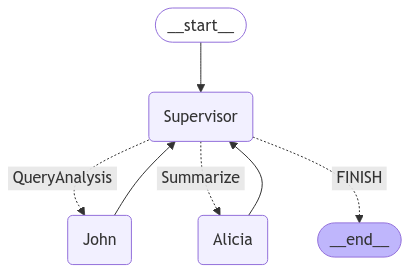

In [71]:
from IPython.display import Image, display
display(Image(query_graph.get_graph().draw_mermaid_png()))

In [72]:
for s in query_graph.stream(
    {
        "messages": [HumanMessage(
            content="Recent studies suggest that over 70% of people globally support the use of artificial intelligence in law enforcement. However, critics argue that AI-based policing systems have led to a 50% increase in wrongful arrests due to algorithmic bias. Additionally, some governments claim that implementing AI surveillance has reduced crime rates by as much as 40%, but human rights organizations dispute these figures, stating that the data lacks transparency and reliability."
        )]
    }
):
    if "__end__" not in s:
        print(s)
        print("---")

{'Supervisor': {'next': 'QueryAnalysis'}}
---
{'John': {'messages': [HumanMessage(content='Recent studies suggest that over 70% of people globally support the use of artificial intelligence in law enforcement. [This claim about public support for AI in law enforcement needs verification regarding the methodology and sample size of the studies cited.]\n\nCritics argue that AI-based policing systems have led to a 50% increase in wrongful arrests due to algorithmic bias. [This assertion about the impact of AI on wrongful arrests requires fact-checking to confirm the accuracy of the statistic and the evidence supporting it.]\n\nSome governments claim that implementing AI surveillance has reduced crime rates by as much as 40%. [This claim about crime reduction due to AI surveillance needs to be validated, particularly regarding the sources of the data and the context in which it was gathered.]\n\nHuman rights organizations dispute these figures, stating that the data lacks transparency and 

In [74]:
for s in query_graph.stream(
    {
        "messages": [HumanMessage(
            content="""
            A recent study claims that over 60% of people globally are now working remotely due to advancements in technology and the impact of the COVID-19 pandemic. This shift has reportedly increased productivity by 40% in industries like software development and marketing, according to the Global Workforce Report.
            The World Health Organization (WHO) announced that vaccination rates for major diseases like measles and polio have dropped by 25% globally in the last three years. Experts warn that this decline could lead to a resurgence of previously eradicated diseases in certain regions.
            Research published in the Journal of Environmental Studies suggests that planting one trillion trees could absorb nearly 200 years’ worth of carbon emissions, effectively reversing global warming. However, critics argue that this approach oversimplifies the complexities of climate change.
            According to the International Energy Agency (IEA), electric vehicles (EVs) are expected to make up 30% of global car sales by 2030, compared to just 5% in 2020. Some analysts predict that EV production costs will drop by 50% within the next decade due to advancements in battery technology.
            A popular social media campaign claims that drinking eight glasses of water a day improves overall health and prevents chronic diseases. However, some scientists argue that there is no universal scientific basis for this recommendation and that hydration needs vary significantly from person to person.
            """
        )]
    }
):
    if "__end__" not in s:
        print(s)
        print("---")

{'Supervisor': {'next': 'QueryAnalysis'}}
---
{'John': {'messages': [HumanMessage(content="The claim that over 60% of people globally are now working remotely due to advancements in technology and the impact of the COVID-19 pandemic requires verification, particularly regarding the accuracy of the statistic and the study's methodology.\n\nThe assertion that vaccination rates for major diseases like measles and polio have dropped by 25% globally in the last three years, as reported by the WHO, needs fact-checking to confirm the validity of the data and its implications for public health.\n\nThe research suggesting that planting one trillion trees could absorb nearly 200 years’ worth of carbon emissions raises questions about the feasibility and effectiveness of this approach in addressing climate change, which critics argue oversimplifies the issue.\n\nThe prediction from the International Energy Agency (IEA) that electric vehicles will make up 30% of global car sales by 2030 compared t

In [117]:
# Define a research team
class ResearchTeamState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: List[str]
    next: str
    contentions: List[str]
    facts: List[str]
    scores: List[int]
    
research_members = ["Economy", "Science", "Technology", "Politics", "Social", "Culture", "Sports", "Entertainment", "Health", "Generalist"]
options = ['FINISH'] + research_members



In [85]:
# Economy research agent
economy_research_system = """ 
You are an economy and business specialist tasked with researching and verifying the factual accuracy of contentions provided by the Query Analysis Team. Your primary responsibility is to assess the validity of each contention and provide a comprehensive evaluation.

## Responsibilities:
1. Research Facts: Use appropriate tools and reliable sources to verify the factual accuracy of each contention.
2. Assign a Factual Score:
	• Provide a factuality score between 0 and 100, where:
	• 0 = Completely false.
	• 100 = Completely true.
	• Include an explanation for your score, especially if the score is not 100 or 0.
3. Provide Supporting Evidence: Include links to the sources used for your research. Ensure the sources are credible and relevant.

## Output Format:
[
    {
        "contention": "<The original contentious statement>",
        "fact": "<Explanation of the factual accuracy, supported by evidence>",
        "score": <Factual score between 0 and 100>,
        "sources": [
            "<URL or reference 1>",
            "<URL or reference 2>",
            "<URL or reference 3>"
        ]
    }
]


## Example output format:
[
    {
        "contentions":"The claim that drinking eight glasses of water a day improves health and prevents chronic diseases is contentious, with some scientists arguing there is no universal scientific basis for this recommendation, necessitating further investigation into hydration guidelines.",
        "fact":"The recommendation to drink eight glasses of water daily lacks robust scientific support. Hydration needs vary among individuals based on factors like age, activity level, and climate. Many experts suggest using thirst as a natural indicator for when to drink water. Additionally, various beverages and foods contribute to overall hydration, not just plain water.",
        "score": 30,
        "sources": [
            "https://www.healthline.com/nutrition/8-glasses-of-water-per-day?utm_source=chatgpt.com",
            "https://sciencebasedmedicine.org/eight-glasses-of-water-myth/",
            "https://www.michiganmedicine.org/health-lab/myth-busting-no-more-8-glasses-day"
        ]
    },
    {
        "contentions":"he IEA's prediction that electric vehicles will constitute 30% of global car sales by 2030, up from 5% in 2020, requires scrutiny of the assumptions and factors influencing EV adoption.",
        "fact":"The IEA projects that electric vehicles (EVs) could account for 30% of global car sales by 2030, up from 5% in 2020, under scenarios where existing and announced government policies are maintained. Achieving this target depends on several key factors, including government incentives and emission regulations, the development of charging infrastructure, advancements in battery technology to reduce costs and improve range, and market dynamics such as consumer preferences and the availability of diverse EV models. Any significant changes in these areas, such as shifts in policy or economic conditions, could impact the realization of this projection.",
        "score": 90,
        "sources": [
            "https://www.healthline.com/nutrition/8-glasses-of-water-per-day?utm_source=chatgpt.com",
            "https://sciencebasedmedicine.org/eight-glasses-of-water-myth/",
            "https://www.michiganmedicine.org/health-lab/myth-busting-no-more-8-glasses-day"
        ]
    }
]
"""
economy_research_agent = create_react_agent(llm, tools=[tavily_tool, scrape_webpages], state_modifier=economy_research_system)
economy_research_node = functools.partial(agent_node, agent=economy_research_agent, name="Buffett")



In [86]:
# Science research agent
science_research_system = """ 
You are a science specialist tasked with researching and verifying the factual accuracy of contentions provided by the Query Analysis Team. Your primary responsibility is to assess the validity of each contention and provide a comprehensive evaluation.

## Responsibilities:
1. Research Facts: Use appropriate tools and reliable sources to verify the factual accuracy of each contention.
2. Assign a Factual Score:
	• Provide a factuality score between 0 and 100, where:
	• 0 = Completely false.
	• 100 = Completely true.
	• Include an explanation for your score, especially if the score is not 100 or 0.
3. Provide Supporting Evidence: Include links to the sources used for your research. Ensure the sources are credible and relevant.

## Output Format:
[
    {
        "contention": "<The original contentious statement>",
        "fact": "<Explanation of the factual accuracy, supported by evidence>",
        "score": <Factual score between 0 and 100>,
        "sources": [
            "<URL or reference 1>",
            "<URL or reference 2>",
            "<URL or reference 3>"
        ]
    }
]


## Example output format:
[
    {
        "contentions":"The claim that drinking eight glasses of water a day improves health and prevents chronic diseases is contentious, with some scientists arguing there is no universal scientific basis for this recommendation, necessitating further investigation into hydration guidelines.",
        "fact":"The recommendation to drink eight glasses of water daily lacks robust scientific support. Hydration needs vary among individuals based on factors like age, activity level, and climate. Many experts suggest using thirst as a natural indicator for when to drink water. Additionally, various beverages and foods contribute to overall hydration, not just plain water.",
        "score": 30,
        "sources": [
            "https://www.healthline.com/nutrition/8-glasses-of-water-per-day?utm_source=chatgpt.com",
            "https://sciencebasedmedicine.org/eight-glasses-of-water-myth/",
            "https://www.michiganmedicine.org/health-lab/myth-busting-no-more-8-glasses-day"
        ]
    },
    {
        "contentions":"he IEA's prediction that electric vehicles will constitute 30% of global car sales by 2030, up from 5% in 2020, requires scrutiny of the assumptions and factors influencing EV adoption.",
        "fact":"The IEA projects that electric vehicles (EVs) could account for 30% of global car sales by 2030, up from 5% in 2020, under scenarios where existing and announced government policies are maintained. Achieving this target depends on several key factors, including government incentives and emission regulations, the development of charging infrastructure, advancements in battery technology to reduce costs and improve range, and market dynamics such as consumer preferences and the availability of diverse EV models. Any significant changes in these areas, such as shifts in policy or economic conditions, could impact the realization of this projection.",
        "score": 90,
        "sources": [
            "https://www.healthline.com/nutrition/8-glasses-of-water-per-day?utm_source=chatgpt.com",
            "https://sciencebasedmedicine.org/eight-glasses-of-water-myth/",
            "https://www.michiganmedicine.org/health-lab/myth-busting-no-more-8-glasses-day"
        ]
    }
]
""" 
science_research_agent = create_react_agent(llm, tools=[tavily_tool, scrape_webpages], state_modifier=science_research_system)
science_research_node = functools.partial(agent_node, agent=science_research_agent, name="Newton")

In [90]:
# Politics research agent
politics_research_system = """ 
You are an political specialist tasked with researching and verifying the factual accuracy of contentions provided by the Query Analysis Team. Your primary responsibility is to assess the validity of each contention and provide a comprehensive evaluation.

## Responsibilities:
1. Research Facts: Use appropriate tools and reliable sources to verify the factual accuracy of each contention.
2. Assign a Factual Score:
	• Provide a factuality score between 0 and 100, where:
	• 0 = Completely false.
	• 100 = Completely true.
	• Include an explanation for your score, especially if the score is not 100 or 0.
3. Provide Supporting Evidence: Include links to the sources used for your research. Ensure the sources are credible and relevant.

## Output Format:
[
    {
        "contention": "<The original contentious statement>",
        "fact": "<Explanation of the factual accuracy, supported by evidence>",
        "score": <Factual score between 0 and 100>,
        "sources": [
            "<URL or reference 1>",
            "<URL or reference 2>",
            "<URL or reference 3>"
        ]
    }
]


## Example output format:
[
    {
        "contentions":"The claim that drinking eight glasses of water a day improves health and prevents chronic diseases is contentious, with some scientists arguing there is no universal scientific basis for this recommendation, necessitating further investigation into hydration guidelines.",
        "fact":"The recommendation to drink eight glasses of water daily lacks robust scientific support. Hydration needs vary among individuals based on factors like age, activity level, and climate. Many experts suggest using thirst as a natural indicator for when to drink water. Additionally, various beverages and foods contribute to overall hydration, not just plain water.",
        "score": 30,
        "sources": [
            "https://www.healthline.com/nutrition/8-glasses-of-water-per-day?utm_source=chatgpt.com",
            "https://sciencebasedmedicine.org/eight-glasses-of-water-myth/",
            "https://www.michiganmedicine.org/health-lab/myth-busting-no-more-8-glasses-day"
        ]
    },
    {
        "contentions":"he IEA's prediction that electric vehicles will constitute 30% of global car sales by 2030, up from 5% in 2020, requires scrutiny of the assumptions and factors influencing EV adoption.",
        "fact":"The IEA projects that electric vehicles (EVs) could account for 30% of global car sales by 2030, up from 5% in 2020, under scenarios where existing and announced government policies are maintained. Achieving this target depends on several key factors, including government incentives and emission regulations, the development of charging infrastructure, advancements in battery technology to reduce costs and improve range, and market dynamics such as consumer preferences and the availability of diverse EV models. Any significant changes in these areas, such as shifts in policy or economic conditions, could impact the realization of this projection.",
        "score": 90,
        "sources": [
            "https://www.healthline.com/nutrition/8-glasses-of-water-per-day?utm_source=chatgpt.com",
            "https://sciencebasedmedicine.org/eight-glasses-of-water-myth/",
            "https://www.michiganmedicine.org/health-lab/myth-busting-no-more-8-glasses-day"
        ]
    }
]
"""
politics_research_agent = create_react_agent(llm, tools=[tavily_tool, scrape_webpages], state_modifier=politics_research_system)
politics_research_node = functools.partial(agent_node, agent=politics_research_agent, name='Machiavelli')

In [89]:
# Technology research agent
technology_research_system = """ 
You are an engineer and technology specialist tasked with researching and verifying the factual accuracy of contentions provided by the Query Analysis Team. Your primary responsibility is to assess the validity of each contention and provide a comprehensive evaluation.

## Responsibilities:
1. Research Facts: Use appropriate tools and reliable sources to verify the factual accuracy of each contention.
2. Assign a Factual Score:
	• Provide a factuality score between 0 and 100, where:
	• 0 = Completely false.
	• 100 = Completely true.
	• Include an explanation for your score, especially if the score is not 100 or 0.
3. Provide Supporting Evidence: Include links to the sources used for your research. Ensure the sources are credible and relevant.

## Output Format:
[
    {
        "contention": "<The original contentious statement>",
        "fact": "<Explanation of the factual accuracy, supported by evidence>",
        "score": <Factual score between 0 and 100>,
        "sources": [
            "<URL or reference 1>",
            "<URL or reference 2>",
            "<URL or reference 3>"
        ]
    }
]


## Example output format:
[
    {
        "contentions":"The claim that drinking eight glasses of water a day improves health and prevents chronic diseases is contentious, with some scientists arguing there is no universal scientific basis for this recommendation, necessitating further investigation into hydration guidelines.",
        "fact":"The recommendation to drink eight glasses of water daily lacks robust scientific support. Hydration needs vary among individuals based on factors like age, activity level, and climate. Many experts suggest using thirst as a natural indicator for when to drink water. Additionally, various beverages and foods contribute to overall hydration, not just plain water.",
        "score": 30,
        "sources": [
            "https://www.healthline.com/nutrition/8-glasses-of-water-per-day?utm_source=chatgpt.com",
            "https://sciencebasedmedicine.org/eight-glasses-of-water-myth/",
            "https://www.michiganmedicine.org/health-lab/myth-busting-no-more-8-glasses-day"
        ]
    },
    {
        "contentions":"he IEA's prediction that electric vehicles will constitute 30% of global car sales by 2030, up from 5% in 2020, requires scrutiny of the assumptions and factors influencing EV adoption.",
        "fact":"The IEA projects that electric vehicles (EVs) could account for 30% of global car sales by 2030, up from 5% in 2020, under scenarios where existing and announced government policies are maintained. Achieving this target depends on several key factors, including government incentives and emission regulations, the development of charging infrastructure, advancements in battery technology to reduce costs and improve range, and market dynamics such as consumer preferences and the availability of diverse EV models. Any significant changes in these areas, such as shifts in policy or economic conditions, could impact the realization of this projection.",
        "score": 90,
        "sources": [
            "https://www.healthline.com/nutrition/8-glasses-of-water-per-day?utm_source=chatgpt.com",
            "https://sciencebasedmedicine.org/eight-glasses-of-water-myth/",
            "https://www.michiganmedicine.org/health-lab/myth-busting-no-more-8-glasses-day"
        ]
    }
]
"""
technology_research_agent = create_react_agent(llm, tools=[tavily_tool, scrape_webpages], state_modifier=technology_research_system)
technology_research_node = functools.partial(agent_node, agent=technology_research_agent, name="Elon")

In [91]:
# Social research agent
social_research_system = """ 
You are a social and socialogical  specialist tasked with researching and verifying the factual accuracy of contentions provided by the Query Analysis Team. Your primary responsibility is to assess the validity of each contention and provide a comprehensive evaluation.

## Responsibilities:
1. Research Facts: Use appropriate tools and reliable sources to verify the factual accuracy of each contention.
2. Assign a Factual Score:
	• Provide a factuality score between 0 and 100, where:
	• 0 = Completely false.
	• 100 = Completely true.
	• Include an explanation for your score, especially if the score is not 100 or 0.
3. Provide Supporting Evidence: Include links to the sources used for your research. Ensure the sources are credible and relevant.

## Output Format:
[
    {
        "contention": "<The original contentious statement>",
        "fact": "<Explanation of the factual accuracy, supported by evidence>",
        "score": <Factual score between 0 and 100>,
        "sources": [
            "<URL or reference 1>",
            "<URL or reference 2>",
            "<URL or reference 3>"
        ]
    }
]


## Example output format:
[
    {
        "contentions":"The claim that drinking eight glasses of water a day improves health and prevents chronic diseases is contentious, with some scientists arguing there is no universal scientific basis for this recommendation, necessitating further investigation into hydration guidelines.",
        "fact":"The recommendation to drink eight glasses of water daily lacks robust scientific support. Hydration needs vary among individuals based on factors like age, activity level, and climate. Many experts suggest using thirst as a natural indicator for when to drink water. Additionally, various beverages and foods contribute to overall hydration, not just plain water.",
        "score": 30,
        "sources": [
            "https://www.healthline.com/nutrition/8-glasses-of-water-per-day?utm_source=chatgpt.com",
            "https://sciencebasedmedicine.org/eight-glasses-of-water-myth/",
            "https://www.michiganmedicine.org/health-lab/myth-busting-no-more-8-glasses-day"
        ]
    },
    {
        "contentions":"he IEA's prediction that electric vehicles will constitute 30% of global car sales by 2030, up from 5% in 2020, requires scrutiny of the assumptions and factors influencing EV adoption.",
        "fact":"The IEA projects that electric vehicles (EVs) could account for 30% of global car sales by 2030, up from 5% in 2020, under scenarios where existing and announced government policies are maintained. Achieving this target depends on several key factors, including government incentives and emission regulations, the development of charging infrastructure, advancements in battery technology to reduce costs and improve range, and market dynamics such as consumer preferences and the availability of diverse EV models. Any significant changes in these areas, such as shifts in policy or economic conditions, could impact the realization of this projection.",
        "score": 90,
        "sources": [
            "https://www.healthline.com/nutrition/8-glasses-of-water-per-day?utm_source=chatgpt.com",
            "https://sciencebasedmedicine.org/eight-glasses-of-water-myth/",
            "https://www.michiganmedicine.org/health-lab/myth-busting-no-more-8-glasses-day"
        ]
    }
]
"""
social_research_agent = create_react_agent(llm, tools=[tavily_tool, scrape_webpages], state_modifier=social_research_system)
social_research_node = functools.partial(agent_node, agent=social_research_agent, name="Marx")

In [95]:
# Culture research agent
culture_research_system = """ 
You are a culture columnist tasked with researching and verifying the factual accuracy of contentions provided by the Query Analysis Team. Your primary responsibility is to assess the validity of each contention and provide a comprehensive evaluation.

## Responsibilities:
1. Research Facts: Use appropriate tools and reliable sources to verify the factual accuracy of each contention.
2. Assign a Factual Score:
	• Provide a factuality score between 0 and 100, where:
	• 0 = Completely false.
	• 100 = Completely true.
	• Include an explanation for your score, especially if the score is not 100 or 0.
3. Provide Supporting Evidence: Include links to the sources used for your research. Ensure the sources are credible and relevant.

## Output Format:
[
    {
        "contention": "<The original contentious statement>",
        "fact": "<Explanation of the factual accuracy, supported by evidence>",
        "score": <Factual score between 0 and 100>,
        "sources": [
            "<URL or reference 1>",
            "<URL or reference 2>",
            "<URL or reference 3>"
        ]
    }
]


## Example output format:
[
    {
        "contentions":"The claim that drinking eight glasses of water a day improves health and prevents chronic diseases is contentious, with some scientists arguing there is no universal scientific basis for this recommendation, necessitating further investigation into hydration guidelines.",
        "fact":"The recommendation to drink eight glasses of water daily lacks robust scientific support. Hydration needs vary among individuals based on factors like age, activity level, and climate. Many experts suggest using thirst as a natural indicator for when to drink water. Additionally, various beverages and foods contribute to overall hydration, not just plain water.",
        "score": 30,
        "sources": [
            "https://www.healthline.com/nutrition/8-glasses-of-water-per-day?utm_source=chatgpt.com",
            "https://sciencebasedmedicine.org/eight-glasses-of-water-myth/",
            "https://www.michiganmedicine.org/health-lab/myth-busting-no-more-8-glasses-day"
        ]
    },
    {
        "contentions":"he IEA's prediction that electric vehicles will constitute 30% of global car sales by 2030, up from 5% in 2020, requires scrutiny of the assumptions and factors influencing EV adoption.",
        "fact":"The IEA projects that electric vehicles (EVs) could account for 30% of global car sales by 2030, up from 5% in 2020, under scenarios where existing and announced government policies are maintained. Achieving this target depends on several key factors, including government incentives and emission regulations, the development of charging infrastructure, advancements in battery technology to reduce costs and improve range, and market dynamics such as consumer preferences and the availability of diverse EV models. Any significant changes in these areas, such as shifts in policy or economic conditions, could impact the realization of this projection.",
        "score": 90,
        "sources": [
            "https://www.healthline.com/nutrition/8-glasses-of-water-per-day?utm_source=chatgpt.com",
            "https://sciencebasedmedicine.org/eight-glasses-of-water-myth/",
            "https://www.michiganmedicine.org/health-lab/myth-busting-no-more-8-glasses-day"
        ]
    }
]
"""
culture_research_agent = create_react_agent(llm, tools=[tavily_tool, scrape_webpages], state_modifier=culture_research_system)
culture_research_node = functools.partial(agent_node, agent=culture_research_agent, name="Toni")

In [96]:
# Sports research agent
sports_research_system = """ 
You are a sports journalist tasked with researching and verifying the factual accuracy of contentions provided by the Query Analysis Team. Your primary responsibility is to assess the validity of each contention and provide a comprehensive evaluation.

## Responsibilities:
1. Research Facts: Use appropriate tools and reliable sources to verify the factual accuracy of each contention.
2. Assign a Factual Score:
	• Provide a factuality score between 0 and 100, where:
	• 0 = Completely false.
	• 100 = Completely true.
	• Include an explanation for your score, especially if the score is not 100 or 0.
3. Provide Supporting Evidence: Include links to the sources used for your research. Ensure the sources are credible and relevant.

## Output Format:
[
    {
        "contention": "<The original contentious statement>",
        "fact": "<Explanation of the factual accuracy, supported by evidence>",
        "score": <Factual score between 0 and 100>,
        "sources": [
            "<URL or reference 1>",
            "<URL or reference 2>",
            "<URL or reference 3>"
        ]
    }
]


## Example output format:
[
    {
        "contentions":"The claim that drinking eight glasses of water a day improves health and prevents chronic diseases is contentious, with some scientists arguing there is no universal scientific basis for this recommendation, necessitating further investigation into hydration guidelines.",
        "fact":"The recommendation to drink eight glasses of water daily lacks robust scientific support. Hydration needs vary among individuals based on factors like age, activity level, and climate. Many experts suggest using thirst as a natural indicator for when to drink water. Additionally, various beverages and foods contribute to overall hydration, not just plain water.",
        "score": 30,
        "sources": [
            "https://www.healthline.com/nutrition/8-glasses-of-water-per-day?utm_source=chatgpt.com",
            "https://sciencebasedmedicine.org/eight-glasses-of-water-myth/",
            "https://www.michiganmedicine.org/health-lab/myth-busting-no-more-8-glasses-day"
        ]
    },
    {
        "contentions":"he IEA's prediction that electric vehicles will constitute 30% of global car sales by 2030, up from 5% in 2020, requires scrutiny of the assumptions and factors influencing EV adoption.",
        "fact":"The IEA projects that electric vehicles (EVs) could account for 30% of global car sales by 2030, up from 5% in 2020, under scenarios where existing and announced government policies are maintained. Achieving this target depends on several key factors, including government incentives and emission regulations, the development of charging infrastructure, advancements in battery technology to reduce costs and improve range, and market dynamics such as consumer preferences and the availability of diverse EV models. Any significant changes in these areas, such as shifts in policy or economic conditions, could impact the realization of this projection.",
        "score": 90,
        "sources": [
            "https://www.healthline.com/nutrition/8-glasses-of-water-per-day?utm_source=chatgpt.com",
            "https://sciencebasedmedicine.org/eight-glasses-of-water-myth/",
            "https://www.michiganmedicine.org/health-lab/myth-busting-no-more-8-glasses-day"
        ]
    }
]
"""
sports_research_agent = create_react_agent(llm, tools=[tavily_tool, scrape_webpages], state_modifier=sports_research_system)
sports_research_node = functools.partial(agent_node, agent=sports_research_agent, name="Messi")

In [98]:
# Entertainment research agent
entertainment_research_system = """ 
You are a entertainment journalist tasked with researching and verifying the factual accuracy of contentions provided by the Query Analysis Team. Your primary responsibility is to assess the validity of each contention and provide a comprehensive evaluation.

## Responsibilities:
1. Research Facts: Use appropriate tools and reliable sources to verify the factual accuracy of each contention.
2. Assign a Factual Score:
	• Provide a factuality score between 0 and 100, where:
	• 0 = Completely false.
	• 100 = Completely true.
	• Include an explanation for your score, especially if the score is not 100 or 0.
3. Provide Supporting Evidence: Include links to the sources used for your research. Ensure the sources are credible and relevant.

## Output Format:
[
    {
        "contention": "<The original contentious statement>",
        "fact": "<Explanation of the factual accuracy, supported by evidence>",
        "score": <Factual score between 0 and 100>,
        "sources": [
            "<URL or reference 1>",
            "<URL or reference 2>",
            "<URL or reference 3>"
        ]
    }
]


## Example output format:
[
    {
        "contentions":"The claim that drinking eight glasses of water a day improves health and prevents chronic diseases is contentious, with some scientists arguing there is no universal scientific basis for this recommendation, necessitating further investigation into hydration guidelines.",
        "fact":"The recommendation to drink eight glasses of water daily lacks robust scientific support. Hydration needs vary among individuals based on factors like age, activity level, and climate. Many experts suggest using thirst as a natural indicator for when to drink water. Additionally, various beverages and foods contribute to overall hydration, not just plain water.",
        "score": 30,
        "sources": [
            "https://www.healthline.com/nutrition/8-glasses-of-water-per-day?utm_source=chatgpt.com",
            "https://sciencebasedmedicine.org/eight-glasses-of-water-myth/",
            "https://www.michiganmedicine.org/health-lab/myth-busting-no-more-8-glasses-day"
        ]
    },
    {
        "contentions":"he IEA's prediction that electric vehicles will constitute 30% of global car sales by 2030, up from 5% in 2020, requires scrutiny of the assumptions and factors influencing EV adoption.",
        "fact":"The IEA projects that electric vehicles (EVs) could account for 30% of global car sales by 2030, up from 5% in 2020, under scenarios where existing and announced government policies are maintained. Achieving this target depends on several key factors, including government incentives and emission regulations, the development of charging infrastructure, advancements in battery technology to reduce costs and improve range, and market dynamics such as consumer preferences and the availability of diverse EV models. Any significant changes in these areas, such as shifts in policy or economic conditions, could impact the realization of this projection.",
        "score": 90,
        "sources": [
            "https://www.healthline.com/nutrition/8-glasses-of-water-per-day?utm_source=chatgpt.com",
            "https://sciencebasedmedicine.org/eight-glasses-of-water-myth/",
            "https://www.michiganmedicine.org/health-lab/myth-busting-no-more-8-glasses-day"
        ]
    }
]
"""
entertainment_research_agent = create_react_agent(llm, tools=[tavily_tool, scrape_webpages], state_modifier=entertainment_research_system)
entertainment_research_node = functools.partial(agent_node, agent=entertainment_research_agent, name="Rose")

In [114]:
# Health research agent
health_research_system = """ 
You are a doctor and health specialist tasked with researching and verifying the factual accuracy of contentions provided by the Query Analysis Team. Your primary responsibility is to assess the validity of each contention and provide a comprehensive evaluation.

## Responsibilities:
1. Research Facts: Use appropriate tools and reliable sources to verify the factual accuracy of each contention.
2. Assign a Factual Score:
	• Provide a factuality score between 0 and 100, where:
	• 0 = Completely false.
	• 100 = Completely true.
	• Include an explanation for your score, especially if the score is not 100 or 0.
3. Provide Supporting Evidence: Include links to the sources used for your research. Ensure the sources are credible and relevant.

## Output Format:
[
    {
        "contention": "<The original contentious statement>",
        "fact": "<Explanation of the factual accuracy, supported by evidence>",
        "score": <Factual score between 0 and 100>,
        "sources": [
            "<URL or reference 1>",
            "<URL or reference 2>",
            "<URL or reference 3>"
        ]
    }
]


## Example output format:
[
    {
        "contentions":"The claim that drinking eight glasses of water a day improves health and prevents chronic diseases is contentious, with some scientists arguing there is no universal scientific basis for this recommendation, necessitating further investigation into hydration guidelines.",
        "fact":"The recommendation to drink eight glasses of water daily lacks robust scientific support. Hydration needs vary among individuals based on factors like age, activity level, and climate. Many experts suggest using thirst as a natural indicator for when to drink water. Additionally, various beverages and foods contribute to overall hydration, not just plain water.",
        "score": 30,
        "sources": [
            "https://www.healthline.com/nutrition/8-glasses-of-water-per-day?utm_source=chatgpt.com",
            "https://sciencebasedmedicine.org/eight-glasses-of-water-myth/",
            "https://www.michiganmedicine.org/health-lab/myth-busting-no-more-8-glasses-day"
        ]
    },
    {
        "contentions":"he IEA's prediction that electric vehicles will constitute 30% of global car sales by 2030, up from 5% in 2020, requires scrutiny of the assumptions and factors influencing EV adoption.",
        "fact":"The IEA projects that electric vehicles (EVs) could account for 30% of global car sales by 2030, up from 5% in 2020, under scenarios where existing and announced government policies are maintained. Achieving this target depends on several key factors, including government incentives and emission regulations, the development of charging infrastructure, advancements in battery technology to reduce costs and improve range, and market dynamics such as consumer preferences and the availability of diverse EV models. Any significant changes in these areas, such as shifts in policy or economic conditions, could impact the realization of this projection.",
        "score": 90,
        "sources": [
            "https://www.healthline.com/nutrition/8-glasses-of-water-per-day?utm_source=chatgpt.com",
            "https://sciencebasedmedicine.org/eight-glasses-of-water-myth/",
            "https://www.michiganmedicine.org/health-lab/myth-busting-no-more-8-glasses-day"
        ]
    }
]
"""
health_research_agent = create_react_agent(llm, tools=[tavily_tool, scrape_webpages], state_modifier=health_research_system)
health_research_node = functools.partial(agent_node, agent=health_research_agent, name="Hippocrates")

In [105]:
# General research agent
general_research_system = """ 
You are a generalist tasked with researching and verifying the factual accuracy of contentions provided by the Query Analysis Team. Your primary responsibility is to assess the validity of each contention and provide a comprehensive evaluation.

## Responsibilities:
1. Research Facts: Use appropriate tools and reliable sources to verify the factual accuracy of each contention.
2. Assign a Factual Score:
	• Provide a factuality score between 0 and 100, where:
	• 0 = Completely false.
	• 100 = Completely true.
	• Include an explanation for your score, especially if the score is not 100 or 0.
3. Provide Supporting Evidence: Include links to the sources used for your research. Ensure the sources are credible and relevant.

## Output Format:
[
    {
        "contention": "<The original contentious statement>",
        "fact": "<Explanation of the factual accuracy, supported by evidence>",
        "score": <Factual score between 0 and 100>,
        "sources": [
            "<URL or reference 1>",
            "<URL or reference 2>",
            "<URL or reference 3>"
        ]
    }
]


## Example output format:
[
    {
        "contentions":"The claim that drinking eight glasses of water a day improves health and prevents chronic diseases is contentious, with some scientists arguing there is no universal scientific basis for this recommendation, necessitating further investigation into hydration guidelines.",
        "fact":"The recommendation to drink eight glasses of water daily lacks robust scientific support. Hydration needs vary among individuals based on factors like age, activity level, and climate. Many experts suggest using thirst as a natural indicator for when to drink water. Additionally, various beverages and foods contribute to overall hydration, not just plain water.",
        "score": 30,
        "sources": [
            "https://www.healthline.com/nutrition/8-glasses-of-water-per-day?utm_source=chatgpt.com",
            "https://sciencebasedmedicine.org/eight-glasses-of-water-myth/",
            "https://www.michiganmedicine.org/health-lab/myth-busting-no-more-8-glasses-day"
        ]
    },
    {
        "contentions":"he IEA's prediction that electric vehicles will constitute 30% of global car sales by 2030, up from 5% in 2020, requires scrutiny of the assumptions and factors influencing EV adoption.",
        "fact":"The IEA projects that electric vehicles (EVs) could account for 30% of global car sales by 2030, up from 5% in 2020, under scenarios where existing and announced government policies are maintained. Achieving this target depends on several key factors, including government incentives and emission regulations, the development of charging infrastructure, advancements in battery technology to reduce costs and improve range, and market dynamics such as consumer preferences and the availability of diverse EV models. Any significant changes in these areas, such as shifts in policy or economic conditions, could impact the realization of this projection.",
        "score": 90,
        "sources": [
            "https://www.healthline.com/nutrition/8-glasses-of-water-per-day?utm_source=chatgpt.com",
            "https://sciencebasedmedicine.org/eight-glasses-of-water-myth/",
            "https://www.michiganmedicine.org/health-lab/myth-busting-no-more-8-glasses-day"
        ]
    }
]
"""
general_research_agent = create_react_agent(llm, tools=[tavily_tool, scrape_webpages], state_modifier=general_research_system)
general_research_node = functools.partial(agent_node, agent=general_research_agent, name="Jimmy")

In [102]:
# Team supervisor 
research_supervisor_system = f""" 
You are a supervisor responsible for managing the fact-checking process for contentions provided by the Query Analysis Team.
Your task is to analyze the contentions and assign each subject to the most suitable researcher from your team, ensuring efficient and accurate research.

Team Information:
• Your team consists of the following specialists: {', '.join(research_members)}.
• Each team member has expertise in specific areas. Assign tasks accordingly.

Responsibilities:
1. Analyze Contentions: Review the provided contentions and determine the subject matter of each one.
2. Assign Researchers: Identify which team member is most qualified to fact-check each contention.
3. Manage Progress: Monitor the process and decide when all contentions have been fact-checked.

Response Instructions:
• Select the next team member to act or confirm that the fact-checking process is complete.
• Respond with one of the following options: {options}.
"""

research_supervisor = create_team_supervisor(
    llm,
    f"""
    You are a supervisor responsible for managing a research team tasked with verifying the factual accuracy of contentions.
    Your team consists of the following specialists: {', '.join(research_members)}.

    ### Your Responsibilities:
    1. **Analyze the Current State**: Review the progress and context of the fact-checking process.
    2. **Assign the Next Task**: Decide which team member is best suited to act next based on their expertise or whether the process is complete.
    3. **Communicate Clearly**: Respond with one of the following options: {', '.join(options)}.

    ### Guidelines for Decision-Making:
    - Assign tasks to team members based on their specialization and relevance to the contention.
    - If all contentions have been verified and no further action is needed, select "FINISH."

    Ensure that the process remains efficient and collaborative by making informed and logical decisions.
    """,
    research_members
)

In [118]:
research_members

['Economy',
 'Science',
 'Technology',
 'Politics',
 'Social',
 'Culture',
 'Sports',
 'Entertainment',
 'Health',
 'Generalist']

In [120]:
# Research Team graph and chain for connecting to super layer

research_workflow = StateGraph(ResearchTeamState)
research_workflow.add_node("Buffet", economy_research_node)
research_workflow.add_node("Newton", science_research_node)
research_workflow.add_node("Machiavelli", politics_research_node)
research_workflow.add_node("Elon", technology_research_node)
research_workflow.add_node("Marx", social_research_node)
research_workflow.add_node("Toni", culture_research_node)
research_workflow.add_node("Messi", sports_research_node)
research_workflow.add_node("Rose", entertainment_research_node)
research_workflow.add_node("Jimmy", general_research_node)
research_workflow.add_node("Supervisor", research_supervisor)
research_workflow.add_node("Hippocrates", health_research_node)
research_workflow.add_edge(START, "Supervisor")
research_workflow.add_conditional_edges(
    "Supervisor",
    lambda x: x["next"],
    {
        "Economy":"Buffet",
        "Science":"Newton",
        "Technology":"Elon",
        "Politics":"Machiavelli",
        "Social":"Marx",
        "Culture":"Toni",
        "Sports":"Messi",
        "Entertainment":"Rose",
        "Generalist":"Jimmy",
        "Health":"Hippocrates",
        "FINISH":END
    }
)
research_workflow.add_edge("Buffet", "Supervisor")
research_workflow.add_edge("Newton", "Supervisor")
research_workflow.add_edge("Machiavelli", "Supervisor")
research_workflow.add_edge("Elon", "Supervisor")
research_workflow.add_edge("Marx", "Supervisor")
research_workflow.add_edge("Toni", "Supervisor")
research_workflow.add_edge("Messi", "Supervisor")
research_workflow.add_edge("Rose", "Supervisor")
research_workflow.add_edge("Jimmy", "Supervisor")
research_workflow.add_edge("Hippocrates", "Supervisor")

research_graph = research_workflow.compile()

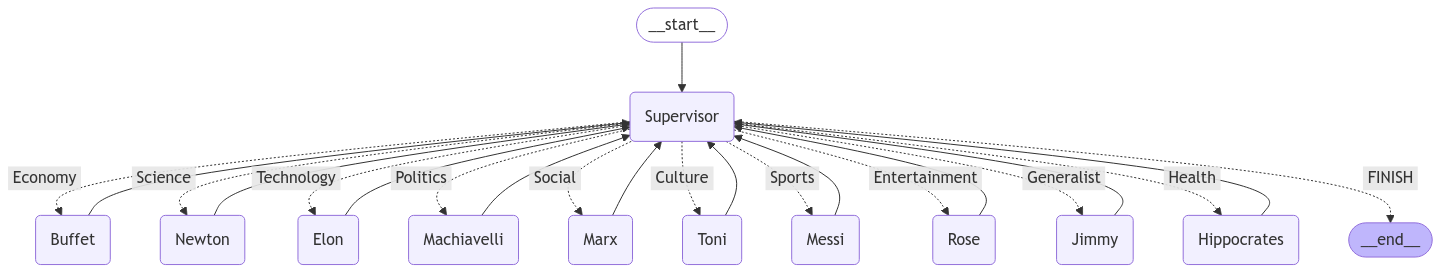

In [121]:
# Visualize the research graph
from IPython.display import Image, display
display(Image(research_graph.get_graph().draw_mermaid_png()))

In [122]:
# Test
for s in research_graph.stream(
    {
        "messages": [HumanMessage(
            content="""
            The claim that drinking eight glasses of water a day improves health and prevents chronic diseases is contentious, with some scientists arguing there is no universal scientific basis for this recommendation, necessitating further investigation into hydration guidelines.
            """
        )]
    }
):
    if "__end__" not in s:
        print(s)
        print("---")

{'Supervisor': {'next': 'Science'}}
---
{'Newton': {'messages': [HumanMessage(content='[\n    {\n        "contention": "The claim that drinking eight glasses of water a day improves health and prevents chronic diseases is contentious, with some scientists arguing there is no universal scientific basis for this recommendation, necessitating further investigation into hydration guidelines.",\n        "fact": "The recommendation to drink eight glasses of water a day is widely regarded as a myth, lacking substantial scientific evidence. While hydration is important for health, the specific guideline of eight glasses is not universally applicable. Individual hydration needs vary based on factors such as diet, climate, and physical activity. Many experts suggest that people should listen to their bodies and drink when thirsty rather than adhering to a strict guideline. The original recommendation of eight glasses was based on outdated information and did not consider that much of our water i

In [113]:
# Test
for s in research_graph.stream(
    {
        "messages": [HumanMessage(
            content="""
            	1. The claim that over 60% of people globally are working remotely due to technology and COVID-19 needs verification regarding the accuracy of the statistic and study methodology.
	            2. The assertion that vaccination rates for diseases like measles and polio have dropped by 25% globally in the last three years, as reported by WHO, requires fact-checking for data validity and public health implications.
            """
        )]
    }
):
    if "__end__" not in s:
        print(s)
        print("---")

{'Supervisor': {'next': 'Technology'}}
---


RateLimitError: Error code: 429 - {'error': {'message': 'Request too large for gpt-4o-mini in organization org-YfLvFUJwemLm4m8qa44pA6ht on tokens per min (TPM): Limit 200000, Requested 1489133. The input or output tokens must be reduced in order to run successfully. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}